# Lab 5


* It is expected that you work individually and the usual plagarism rules apply.
* Submissions are to be made on canvas. Make sure that you add your student ID in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name].ipynb", for example "Lab2_Bongers.ipynb". 
* Please make sure your code will run without problems

_You need to fill in everywhere that there is a_ '__TODO__'

Feel free ask any questions during the computer lab sessions, or email the TA.

**The due date for the labs is next Wednesday at 14:59**

## Part 1


In this part of the lab you will plot the prior, posterior and predictive distributions for a set of data that we assume to follow an exponential distribution.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.datasets

from scipy import integrate

Statsmodels is a Python package for conducting statistical data analyses. It also contains real-world datasets that we can use when experimenting with new methods. Here, we load the heart dataset. Each line indicates the number of days that a patient survived after a heart transplant, together with the age of the patient.

Here you can have a look at the 5 last lines of the data frame.

In [2]:
data_original = statsmodels.datasets.heart.load_pandas().data
data_original.tail()

,survival,censors,age
64,14.0,1.0,40.3
65,167.0,0.0,26.7
66,110.0,0.0,23.7
67,13.0,0.0,28.9
68,1.0,0.0,35.2


This dataset contains censored and uncensored data: a censor of $0$ means that the patient was alive at the end of the study, and thus we don't know the exact survival time. We only know that the patient survived at least the indicated number of days. For simplicity here, we only keep uncensored data (we thereby introduce a bias toward patients that did not survive very long after their transplant) and we store it in an array 'data_full'. We also divided each number by 365, so the period of time that a patient survived a heart transplant is given in years.

In [3]:
data_original = data_original[data_original.censors == 1]
survival = data_original.survival
survival=np.array(survival)
data_full=survival/365

In the array 'data', we store the first 'p' elements of 'data_complete'. First, we let 'p' be $10$. The idea is we are going to predict the distribution of the survival time only using 'p' data (while the full dataset contains $69$ data) and later, we can play with the value of 'p' and see how many data are actually needed to have a satisfying prediction. We also plot the data. 

Text(0.5,1,'Scatter plot of training data $\\mathcal{D}$')

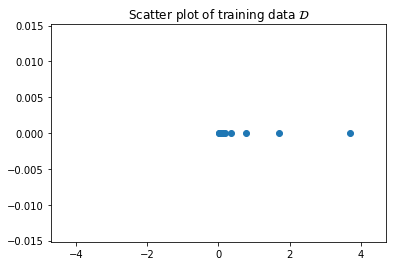

In [4]:
# restricting the data to p elements
p=10
data=data_full[:p]
N=len(data)

# plotting the data
datamin = np.amin(data)
datamax = np.amax(data)
absmax = np.maximum(np.abs(datamin), np.abs(datamax)) + 1
plt.figure(0)
plt.scatter(data, np.zeros(data.shape))
plt.xlim(-absmax, absmax)
plt.title('Scatter plot of training data $\mathcal{D}$', fontsize=12)

We assume that the data follows an exponential distribution with parameter $\lambda$. That is,
$$
p(x|\lambda)=\lambda e^{-\lambda x}
$$
We also suppose that the prior distribution for $\lambda$ is a Gamma distribution with parameters $\alpha$ and $\beta$
$$
p(\lambda | \alpha, \beta)= \frac{1}{Z(\alpha,\beta)} x^{\alpha-1} e^{-\beta x}
$$
Initially, we suppose $\alpha=2$ and $\beta=2$. We start by plotting the prior distribution. The code below plots the function
$$
x^{\alpha-1} e^{-\beta x}
$$
So if we would normalize that function, we would obtain the prior distribution. It is *almost* the prior, the problem being that the area under the graph might not be $1$.

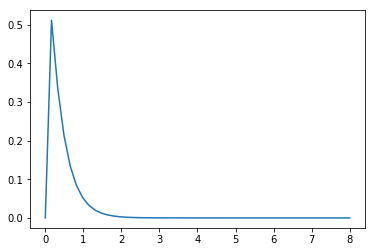

In [5]:
#plotting the prior up to a constant (not normalized)

def gam(x,alpha=1.1,beta=3):
    return x**(alpha-1)*np.exp(-x*beta)

alpha=1.1
beta=3
x=np.linspace(0,8,50)
plt.plot(x,gam(x, alpha=alpha, beta=beta))
plt.show()

One way from the previous graph to obtain the prior distribution is to define a function `area(func,a,b)` that computes the area under the graph of the function `func` in the interval $[a,b]$. Then we define a function `norm_plot(func,a,b,legend)` which given a function `func` and an interval $[a,b]$, plots the *normalized* graph of `func` in the interval $[a,b]$ and write `legend` as a legend of the graph. You don't have to write the code for `norm_plot(func,a,b,legend)`, but make sure you understand how it works.  

__TODO1__ (0.5 pt) Define the function `area(func,a,b)`. In order to compute the area under the graph of a function, we use integration. You can use the following built-in function to define  `area(func,a,b)`:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

Make sure that the output is indeed a scalar.

In [6]:
def area(func,a,b):
    #to be filled in by the students
    

def norm_plot(func,a,b,legend):
    x=np.linspace(a,b,100)
    norm_func=func(x)*(1/area(func,a,b))
    plt.plot(x,norm_func,label=legend)

IndentationError: expected an indented block (<ipython-input-6-8fdf35e506f0>, line 5)

__TODO2__(0.5 pt) Using the function `norm_plot`, plot the prior distribution in the interval $[0,8]$.

In [ ]:
#plot the prior


plt.legend()
plt.show()

The formula for calculating the posterior distribution is 
$$
p(\lambda|\mathcal{D}) = \frac{p(\mathcal{D}|\lambda)p(\lambda)}{p(\mathcal{D})}
$$
where $\mathcal{D}$ is the training data. Before calculating analytically the posterior distribution for $\lambda$, we will compute by brute force the value of $\lambda$, which we call $\lambda_{\text{brute force}}$, such that $p(\lambda_{\text{brute force}}|\mathcal{D})$ is maximized. 

Given the above equation, we know that
$$
p(\lambda|\mathcal{D}) \propto p(\mathcal{D}|\lambda)p(\lambda)
$$
So we have to find $\lambda_{\text{brute force}}$ such that 
$$
p(\mathcal{D}|\lambda_{\text{brute force}})p(\lambda_{\text{brute force}})
$$
is maximized. 

The idea is that for *enough* $\lambda_1, \dots,\lambda_k$, we compute the array `A`
$$
\texttt{A} = \begin{bmatrix}
p(\mathcal{D}|\lambda_1)p(\lambda_1) \\
p(\mathcal{D}|\lambda_2)p(\lambda_2) \\
\dots \\
p(\mathcal{D}|\lambda_k)p(\lambda_k)
\end{bmatrix}
$$
and then using the `argmax` function (as in a previous assignment), we find the $\lambda_i$ corresponding to the highest value in `A`. This $\lambda_i$ is our $\lambda_{\text{brute force}}$. 

__TODO3__ (1 pt) Write a program that outputs the value of the variable `lambda_brute_force`, which should be $\lambda_{\text{brute force}}$. It should follow the steps of the method described above. In order to generate the set $\{ \lambda_1, \dots,\lambda_k \}$, you can use `np.linspace(0,10,k)`. Then define the array `A` as above. Note that $p(\mathcal{D}|\lambda_j)$ refers to an exponential distribution with parameter $\lambda_j$ and $p(\lambda_j)$ refers to a gamma distribution with parameters $\alpha$ and $\beta$ ($\alpha$ and $\beta$ have the same values as before). Finally, using `argmax`, find the $\lambda_i$ corresponding to the highest value of `A`. 

__BONUS__ (1.5 pt) Write the program without using any `for` loops.

In [ ]:
k=50



#given
print("The brute force estimator of lambda is: ", lambda_brute_force)

__TODO4__ (1 pt) Define `alpha_post` and `beta_post` as the parameters of the posterior distribution (the formulas for `alpha_post` and `beta_post` are the answers from the first question of the tutorial). Plot the posterior distribution using the function `norm_plot`. Note that this time, you cannot use the function `gam` as this function has parameters $\alpha$ and $\beta$ (and the parameters should be `alpha_post` and `beta_post`). So you need to define a new function as an input for `norm_plot`. 

We also plotted for you the prior distribution and the brute force estimator. So you can compare those with the posterior distribution.

In [ ]:
#plot the posterior distribution, to be filled in


#plot the prior distribution, given
norm_plot(gam,0,8,'Prior')

#plot the brute force operator, given
plt.plot(20*[lambda_brute_force],np.linspace(0,1.2,20),label='Brute force estimator')
plt.legend()
plt.show()

__TODO5__ (0.5 pt) Try again to run the above program with different values for `p` and for $\alpha$ and $\beta$. Starting from which value of `p`, are we starting to have a stable prediction? (that is, how much data is sufficient to have already a satisfying prediction?) What happens when we start with different values of $\alpha$ and $\beta$? Does it affect a lot the posterior distribution?

__TODO6__ (1 pt) Draw a random sample $S$ of size `M`from the posterior distribution $p(\lambda | \mathcal{D})$. Then, for each value of $\lambda$ in $S$, draw the exponential distribution with parameter $\lambda$. In order to draw the random sample, you can use the following built-in function
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.gamma.html

In [ ]:
#represent various p(x|lambda) for different lambda ~ p(lambda|data)
M=5


We compute now the maximum a posteriori (MAP) estimator of $\lambda$, which is the mode of the posterior distribution. In case of a gamma distribution with parameters $\alpha$ and $\beta$, the mode is given by
$$
\frac{\alpha-1}{\beta}
$$

__TODO7__ (1 pt) Compute the MAP estimator  $\lambda_{MAP}$ of $\lambda$. Compute also the maximum likelihood estimator $\lambda_{ML}$ of $\lambda$ (recall that it is equal to $\frac{N}{\sum_i x_i}$, where $\{ x_1, \dots, x_n\}$ is the set of `data`). Then plot the exponential distribution with parameter $\lambda_{MAP}$ and the exponential distribution with parameter $\lambda_{ML}$. How do the two estimators compare to each other? And how do they compare with the brute force estimator?

In [ ]:
#compute the MAP estimator of lambda using the theoretical formula, to be filled in


#compute the ML estimator of lambda, to be filled in


#print again the brute force estimator, given
print('The brute force estimator of lambda is: ',lambda_brute_force)
plt.plot(x,expo(x,lambda_brute_force),label='brute force $\lambda$')
plt.legend()
plt.show()

Finally we plot the predictive distribution. It is the distribution for future predicted test data based on the training data we have been given. So the posterior predictive distribution can be used to predict new data values. In the case of an exponential distribution for the data and a prior which is a gamma distribution, the predictive distribution is given by
$$
\frac{\alpha'(\beta')^{\alpha'}}{(\beta'+x)^{\alpha'+1}}
$$
where $\alpha'$ and $\beta'$ are the parameters of the posterior distribution. 

__TODO8__ (1 pt) Plot the predictive distribution.

In [ ]:
#compute the distributive and compare with p(x|lambda_MAP), given
plt.plot(x,expo(x,lambda_MAP),label='exponential distr. with MAP $\lambda$')

#compute the predictive distribution, to be filled in

plt.legend()
plt.show()

# Part 2

We will now do the same analysis but for a different distribution and slightly different type of problem.

## Bayesian linear regression

We consider the standard one dimensional linear regression problem
$$
y=wx+b+\epsilon
$$

We assume that the noise $\epsilon \sim \mathcal{N}(0,\sigma^2)$. We are being given some data 
$$
\mathcal{D} =\{ (x_1,y_1), \dots, (x_N,y_N) \}
$$
and we want to find estimators for the parameters $w$ and $b$ (note that here we assume $\sigma^2$ to be known, there is also a bayesian analysis where $\sigma^2$ is considered as an extra parameter to be estimated). 

First we randomly generate some data. The array `xdata` contains all the values $x_1, \dots, x_N$ and the array `ydata`contains the values $y_1,\dots,y_N$. We will also denote by $\vec{y}$ the vector
$$
\begin{bmatrix}
y_1 \\
\dots \\
y_N
\end{bmatrix}
$$
and by $X$ the matrix:
$$
\begin{bmatrix}
x_1 & \dots & x_N \\
1 & \dots & 1 
\end{bmatrix}
$$
(note that if you are looking at Section 3.3 of Bishop, this is the transpose of the design matrix)

In [ ]:
#randomly generate the data

import random

N_reg = 100
wtrue = 5+2*np.random.rand()
btrue = 1+np.random.randn()

xdata = 4*(np.random.rand(N_reg)-0.5)
xdata = np.sort(xdata)

sigmatrue=2+np.random.randn()
noisedata=np.random.normal(0, sigmatrue, N_reg)

ydata= wtrue* xdata + btrue + noisedata
plt.plot(xdata,ydata,"r.")

print('The true parameters for w and b are', wtrue,'and', btrue)

We have that
$$
y \sim \mathcal{N}(b,\sigma^2)
$$

Usually we assume that the distribution of the parameters $(w,b)$ is a 2D gaussian, which will ensure that the posterior is also a gaussian. So
$$
p(w,b) = \mathcal{N}(\vec{\mu},\Sigma) 
$$


First we plot the prior distribution (using contour lines). Make sure you understand the code. The prior distribution of the parameters $w$ and $b$ is a 2-dimensional gaussian with mean `m` and covariance matrix `cov`

In [ ]:
from scipy.stats import multivariate_normal

#everything given
m=[10,8]
cov = [[4, 0], [0, 4]]

N_w=200
N_b=100
w0 = np.linspace(5, 15, N_w)
b0 = np.linspace(5,14,N_b)
W, B = np.meshgrid(w0, b0)
pos=np.dstack((W,B))

plt.contour(W,B, multivariate_normal.pdf(pos,m,cov))

Like in the first part of the assignment, we will first compute brute force estimators of $w$ and $b$. The technique is the same but it is technically slightly more involved as we have 2 parameters instead of 1. We start with an array with *enough* different values of $w$ and $b$

$$
\begin{bmatrix}
[w_{11},b_{11}] & [w_{12},b_{12}] & \dots & [w_{1k},b_{1k}] \\
[w_{21},b_{21}] & [w_{22},b_{22}] & \dots & [w_{2k},b_{2k}] \\
\dots & & & \\
[w_{1l},b_{1l}] & [w_{1},b_{11}] & \dots & [w_{11},b_{11}] \\
\end{bmatrix}
$$

For this array, we will simply use the array `pos` from the previous program (it is a 3D array with dimension (N_b, N_w, 2) ).

As in the case of the exponential distribution, for each $[w_{ij},b_{ij}]$, we will compute the value

$$
p(\vec{y} \;| \; w_{ij},b_{ij},X)  p(w_{ij},b_{ij})
$$
and the brute force estimator will be the pair $(w_{ij},b_{ij})$ that maximizes that value.

### Array_param

In the array `array_param`, we will store all the values
$$
 p(w_{ij},b_{ij})
$$

Note that `array_param` is thus a 2D array of shape `(N_b,N_w)`. 

Remember that the probability distribution of $(w,b)$ is a 2-dimensional gaussian with mean `m` (vector of size $2$) and $2 \times 2$ covariance matrix `cov`. You can use any built-in function that you want. 

### Array_like

Next in the array `array_like` (`like` as for likelihood), we will store all the values

$$
p(\vec{y} \;| \; w_{ij},b_{ij},X) 
$$
for each of the values of $[w_{ij},b_{ij}]$. Again  `array_like` is thus a 2D array of shape `(N_b,N_w)`.

In case of linear regession, the likelihood is given by
$$
p(\vec{y} \;| \; w_{ij},b_{ij},X) = \mathcal{N}(X^T \vec{w}_{ij}, \sigma^2 I) 
$$
where $I$ is the identity matrix of dimension $N$ and
$$
\vec{w}_{ij} =\begin{bmatrix} w_{ij} \\ b_{ij} \end{bmatrix}
$$

### Array B

Finally, in the array `B`, we will store all the values
$$
p(\vec{y} \;| \; w_{ij},b_{ij},X)  p(w_{ij},b_{ij})
$$

So, `B=np.multiply(array_param,array_like)`. Note that the 3 arrays `array_param`, `array_like` and `B`are arrays of shape `(N_b,N_w)`.

Finally we have to find the value of $[w_{ij},b_{ij}]$ that corresponds to the maximum value of `B`. This can be done applying the `argmax` function to `B`. It is not as easy as in Part 1 though as for a given array `B` the result of `argmax`will be an index of the flattened array obtained from `B` (have a look at the documentation). In order to obtain the index of the maximum of the original unflattened `B`, you can for example use the function `unravel_index` from numpy (have also a look at the documentation to know how to use `unravel_index`).


__TODO9__ (1.5 pt) Compute the brute force estimators of $w$ and $b$ using the method described above (and using the same names for the arrays).

In [ ]:
#initialize the matrix X (needed for the likelihood later), given
X=np.zeros((2,N_reg))
X[0]=xdata
X[1] =1.0

#to be filled in 

Now in order to find estimators of $w$ and $b$ (without using brute force), we will compute the posterior distribution of $(w,b)$ and take the maximum as an estimators of $(w,b)$.

If you look in Bishop (section 3.3), you can see that the posterior distribution is given by
$$
p(w,b \; | \; \sigma,\mathcal{D}) \sim \mathcal{N}(\vec{\mu}_{post},\Sigma_{post})
$$
where
$$
\Sigma_{post}^{-1} = \Sigma^{-1} + \frac{1}{\sigma^2} X X^T
$$
and 
$$
\vec{\mu}_{post} = \Sigma_{post} (\Sigma^{-1} \vec{\mu} + \frac{1}{\sigma^2} X \vec{y})
$$


__TODO10__ (1 pt) Using the same method as for plotting the prior, plot the posterior distribution of $(w,b)$.

__TODO11__ (0.5 pt) Compute the MAP estimator $(w_{MAP},b_{MAP})$ of $(w,b)$ (so that is the mode of the posterior distribution and in the case of a gaussian, this is the mean of the gaussian). Next plot the line with equation
$$
y= w_{MAP} x + b_{MAP}
$$

Did you see a time difference bewteen the computation of the estimators using brute force and using the Bayesian approach? What happens when you increase the values of `N_b` and `N_w`?

In [ ]:

#given
plt.plot(xdata,ydata,"r.")
plt.legend()